In [169]:
import pandas as pd
import requests as req
import matplotlib.pyplot as plt
import numpy as np
import time, random
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

HEADERS = \
    {
    'user-agent': ('Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36'),  # noqa: E501
    'Dnt': ('1'),
    'Accept-Encoding': ('gzip, deflate, sdch'),
    'Accept-Language': ('en'),
    'origin': ('http://stats.nba.com')
    }

In [2]:
def get_player_IDs():
    url_pids = 'http://stats.nba.com/stats/commonallplayers?IsOnlyCurrentSeason=1&LeagueID=00&Season=2017-18'
    response_pids = req.get(url_pids, headers=HEADERS)
    col_names = response_pids.json()['resultSets'][0]['headers']
    col_data = response_pids.json()['resultSets'][0]['rowSet']
    df_pids = pd.DataFrame(col_data,columns=col_names)
    df_pids = df_pids[df_pids['ROSTERSTATUS'] == 1]
    return df_pids[['PERSON_ID','DISPLAY_FIRST_LAST']]

def get_player_ID(player_name):
    player_id_list = get_player_IDs()
    playerID = [player[0] for player in player_id_list if player[1].lower() == player_name.lower()]
    return playerID


In [3]:
def get_player_stats():
    PIDs = get_player_IDs()
    template = 'http://stats.nba.com/stats/playerdashboardbyyearoveryear?DateFrom=&DateTo=&GameSegment=&LastNGames=0'\
    '&LeagueID=00&Location=&MeasureType={}&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N'\
    '&PerMode=PerGame&Period=0&PlayerID={}&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment='\
    '&SeasonType=Regular+Season&ShotClockRange=&Split=yoy&VsConference=&VsDivision='
    list_player_dfs=list()
    for i,pid in tqdm(enumerate(PIDs['PERSON_ID'])):
        player_stats_url = template.format('Base',str(pid)) # Basic player stats
        player_stats_response = req.get(player_stats_url, headers=HEADERS).json()['resultSets'][0]
        col_names = player_stats_response['headers']
        if player_stats_response['rowSet']: col_vals  = player_stats_response['rowSet'][0]
        else: continue
        pframe = pd.DataFrame(col_vals, index=col_names).transpose()
        pframe['PlayerID'] = pid
        list_player_dfs.append(pframe)
        time.sleep(random.betavariate(1,3))
    df_final = pd.concat(list_player_dfs).set_index('PlayerID',drop=True)
    return df_final

In [4]:
basic_player_stats = get_player_stats()

505it [11:55,  1.42s/it]


In [5]:
player_data_final = get_player_IDs().set_index('PERSON_ID').join(basic_player_stats).dropna()
player_data_final = player_data_final.loc[player_data_final['TEAM_ID'] != -1]
player_data_final.columns

Index(['DISPLAY_FIRST_LAST', 'GROUP_SET', 'GROUP_VALUE', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'MAX_GAME_DATE', 'GP', 'W', 'L', 'W_PCT', 'MIN',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA',
       'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK',
       'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
       'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
       'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
       'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK',
       'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK', 'CFID', 'CFPARAMS'],
      dtype='object')

In [226]:
# cols = [c for c in player_data_final.columns if 'rank' not in c.lower()]
cols = ['MIN','FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA',
       'PF', 'PFD', 'PTS', 'PLUS_MINUS']
player_data_final = player_data_final[cols]
print(player_data_final.columns)
player_data_final.head()

Index(['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA',
       'PF', 'PFD', 'PTS', 'PLUS_MINUS'],
      dtype='object')


,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
203518,15.1,1.5,3.9,0.395,1.1,2.9,0.38,0.5,0.6,0.848,...,1.5,0.4,0.3,0.5,0.1,0.1,1.7,0.7,4.7,0.6
203112,19.4,1.9,5.2,0.356,1.5,4.2,0.349,0.7,0.9,0.817,...,3.7,0.8,0.9,0.5,0.4,0.2,2.1,1.2,5.9,-0.8
203500,32.7,5.9,9.4,0.629,0,0,0,2.1,3.8,0.557,...,9,1.2,1.7,1.2,1,0.6,2.8,3.7,13.9,4.2
1628389,19.8,2.5,4.9,0.512,0,0.1,0,1.9,2.6,0.721,...,5.5,1.5,1,0.5,0.6,0.4,2,2.5,6.9,-0.5
201167,12.9,1.2,3.1,0.401,0.5,1.3,0.386,0.4,0.5,0.846,...,1.2,0.6,0.4,0.1,0.2,0.2,1.1,0.5,3.4,-1.8


In [7]:
player_data_final.to_csv('player_data.csv')

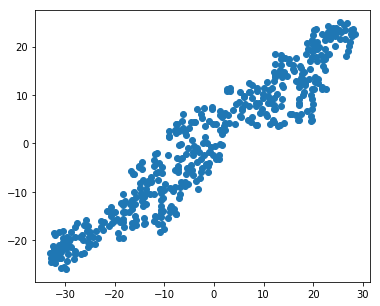

In [8]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(player_data_final)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.legend()
plt.show()


In [190]:
# this takes ~10 mins to run
def get_player_salaries():
    salaries = list()
    for i in range(13):
        sal_url = 'http://www.espn.com/nba/salaries'
        if i > 1: sal_url = sal_url + '/_/page/{}'.format(i)
        salaries_i = pd.read_html(sal_url,header=0,index_col=0,thousands=',')[0]
        salaries_i = salaries_i.loc[salaries_i.NAME!='NAME']
        salaries.append(salaries_i)
    salaries_final = pd.concat(salaries)
    salaries_final['POSITION'] = salaries_final['NAME'].map(lambda x: x.split(',')[1].strip())
    #print (salaries_final)
    salaries_final['NAME'] = salaries_final['NAME'].map(lambda x: x.split(',')[0])
    salaries_final['SALARY'] = salaries_final['SALARY'].map(lambda x: str(x)[1:].replace(',', ''))
    salaries_final['SALARY'] = pd.to_numeric(salaries_final['SALARY'])
    return salaries_final
salaries = get_player_salaries()

In [191]:
salaries = get_player_salaries()
salaries = salaries.reset_index(drop=True)
salaries = salaries.set_index('NAME').join(get_player_IDs().set_index('DISPLAY_FIRST_LAST'),).dropna()
salaries['PERSON_ID']=salaries.PERSON_ID.astype(int)
salaries.drop_duplicates(inplace=True)

In [192]:
df_total = player_data_final.merge(salaries,left_index=True,right_on='PERSON_ID')

In [193]:
columns_tot = ['MIN','FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
        'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA',
       'PF', 'PFD', 'PLUS_MINUS','POSITION']
columns_transf = ['MIN','FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
        'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA',
       'PF', 'PFD', 'PLUS_MINUS']

In [217]:
player_data_transform = df_total[columns_tot]
player_data_transform[columns_transf] = player_data_transform[columns_transf].astype(float)
column_nomin = list(set(columns_transf)-{'MIN'})
player_data_transform[column_nomin] =player_data_transform[column_nomin].div(player_data_transform['MIN'],axis=0)
player_data_transform.drop(['MIN'],axis=1,inplace=True)
player_data_transform = player_data_transform[player_data_transform.POSITION.isin(['SF','PF','C'])]

In [230]:
player_data_transform.head()
player_data_latex = player_data_transform.iloc[:10].to_latex()

In [233]:
player_data_transform

,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS,POSITION
Quincy Acy,0.097938,0.268041,0.077320,0.216495,0.036082,0.046392,0.030928,0.159794,0.041237,0.046392,0.025773,0.020619,0.010309,0.108247,0.061856,-0.041237,SF
Steven Adams,0.180428,0.287462,0.000000,0.000000,0.064220,0.116208,0.155963,0.122324,0.036697,0.051988,0.036697,0.030581,0.018349,0.085627,0.113150,0.128440,C
Bam Adebayo,0.126263,0.247475,0.000000,0.005051,0.095960,0.131313,0.085859,0.191919,0.075758,0.050505,0.025253,0.030303,0.020202,0.101010,0.126263,-0.025253,C
Cole Aldrich,0.086957,0.304348,0.000000,0.000000,0.043478,0.130435,0.043478,0.260870,0.043478,0.000000,0.043478,0.000000,0.000000,0.217391,0.043478,-0.043478,C
LaMarcus Aldridge,0.275449,0.538922,0.011976,0.035928,0.134731,0.158683,0.098802,0.155689,0.059880,0.044910,0.017964,0.035928,0.017964,0.062874,0.137725,0.110778,PF
Jarrett Allen,0.165000,0.275000,0.005000,0.010000,0.080000,0.100000,0.100000,0.170000,0.035000,0.055000,0.020000,0.060000,0.025000,0.100000,0.075000,-0.095000,C
Al-Farouq Aminu,0.110000,0.280000,0.060000,0.163333,0.030000,0.040000,0.046667,0.206667,0.040000,0.036667,0.036667,0.020000,0.006667,0.066667,0.040000,0.106667,PF
Kyle Anderson,0.116105,0.220974,0.011236,0.029963,0.052434,0.074906,0.041199,0.157303,0.101124,0.048689,0.059925,0.029963,0.014981,0.056180,0.059925,0.071161,SF
Ryan Anderson,0.118774,0.279693,0.076628,0.195402,0.042146,0.053640,0.053640,0.137931,0.034483,0.022989,0.015326,0.011494,0.007663,0.072797,0.049808,0.145594,PF
Ike Anigbogu,0.148148,0.296296,0.000000,0.000000,0.185185,0.185185,0.185185,0.148148,0.000000,0.074074,0.037037,0.111111,0.074074,0.037037,0.111111,-0.481481,C


'plt.scatter(X_2d_t[:, 0], X_2d_t[:, 1])\nplt.legend()\nplt.show()'

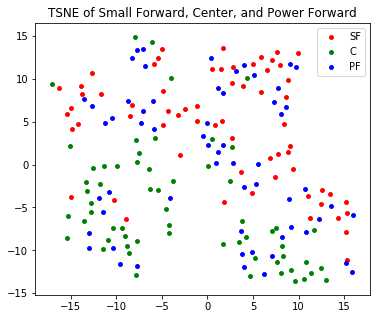

In [234]:
column_nomin_nopos = list(set(column_nomin)-{'POSITION'})
tsne = TSNE(perplexity=20,learning_rate = 10)
X_2d_t = tsne.fit_transform(player_data_transform[column_nomin_nopos])
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k'
fash_labels = player_data_transform.POSITION.unique()
names = fash_labels
for i, c, label in zip(fash_labels, colors, names):
    plt.scatter(X_2d_t[player_data_transform.POSITION == i, 0], X_2d_t[player_data_transform.POSITION == i, 1], c=c,s=15, label=label)
plt.legend(markerscale=1)
plt.title('TSNE of Small Forward, Center, and Power Forward');

"""plt.scatter(X_2d_t[:, 0], X_2d_t[:, 1])
plt.legend()
plt.show()"""

In [291]:
def calc_inter_intra(values,labels):
    tot_var = values.var()
    uniq_lab = list(set(labels))
    intra_var = sum([values[labels==n].var()*sum(labels==n)/(len(labels)) for n in uniq_lab])
    inter_var = tot_var - intra_var
    return inter_var/tot_var

Intra_class/Inter_class Variance 0.16886356424


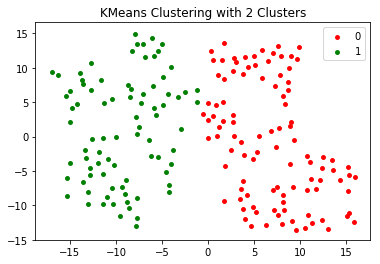

In [292]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_2d_t)
colors = 'r','g','b','c','m'
fash_labels = list(set(kmeans.labels_))
names = fash_labels
for i, c, label in zip(fash_labels, colors, names):
    plt.scatter(X_2d_t[kmeans.labels_ == i, 0], X_2d_t[kmeans.labels_ == i, 1], c=c,s=15, label=label)
plt.legend(markerscale=1)
print ("Intra_class/Inter_class Variance",calc_inter_intra(X_2d_t,kmeans.labels_))
plt.title("KMeans Clustering with 2 Clusters");

Intra_class/Inter_class Variance 0.274321838072


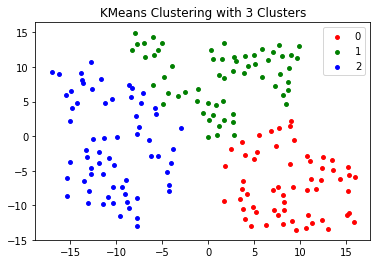

In [293]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_2d_t)
colors = 'r','g','b','c','m'
fash_labels = list(set(kmeans.labels_))
names = fash_labels
for i, c, label in zip(fash_labels, colors, names):
    plt.scatter(X_2d_t[kmeans.labels_ == i, 0], X_2d_t[kmeans.labels_ == i, 1], c=c,s=15, label=label)
plt.legend(markerscale=1)
print ("Intra_class/Inter_class Variance",calc_inter_intra(X_2d_t,kmeans.labels_))
plt.title("KMeans Clustering with 3 Clusters");

Intra_class/Inter_class Variance 0.294901514376


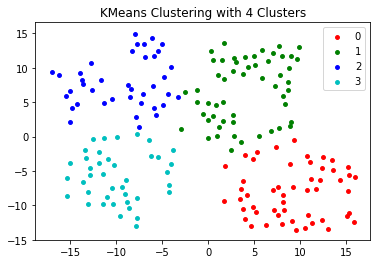

In [294]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_2d_t)
colors = 'r','g','b','c','m'
fash_labels = list(set(kmeans.labels_))
names = fash_labels
for i, c, label in zip(fash_labels, colors, names):
    plt.scatter(X_2d_t[kmeans.labels_ == i, 0], X_2d_t[kmeans.labels_ == i, 1], c=c,s=15, label=label)
plt.legend(markerscale=1)
print ("Intra_class/Inter_class Variance",calc_inter_intra(X_2d_t,kmeans.labels_))
plt.title("KMeans Clustering with 4 Clusters");

Intra_class/Inter_class Variance 0.326017814095


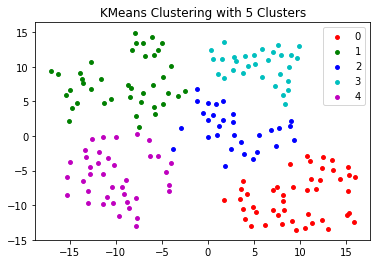

In [295]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_2d_t)
colors = 'r','g','b','c','m'
fash_labels = list(set(kmeans.labels_))
names = fash_labels
for i, c, label in zip(fash_labels, colors, names):
    plt.scatter(X_2d_t[kmeans.labels_ == i, 0], X_2d_t[kmeans.labels_ == i, 1], c=c,s=15, label=label)
plt.legend(markerscale=1)
print ("Intra_class/Inter_class Variance",calc_inter_intra(X_2d_t,kmeans.labels_))
plt.title("KMeans Clustering with 5 Clusters");

In [274]:
print(X_2d_t.var())
labels = list(set(kmeans.labels_))
print(sum([X_2d_t[kmeans.labels_==n].var()*sum(kmeans.labels_==n)/(len(kmeans.labels_)) for n in labels]))

74.0079


52.182887969145895

In [304]:
elbow = []
for n in range(1,10):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X_2d_t)
    elbow.append(calc_inter_intra(X_2d_t,kmeans.labels_))

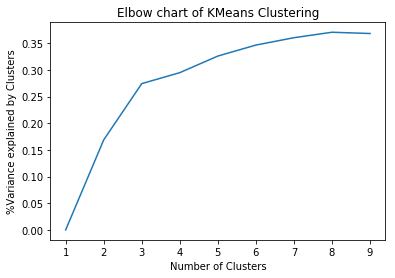

In [307]:
plt.plot([n for n in range(1,10)],elbow)
plt.title("Elbow chart of KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("%Variance explained by Clusters");